# Проект по AB-тестам. Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.  
  
В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("dating_data.csv")

# EDA

In [3]:
df.shape

(14514, 4)

In [4]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


Чтобы не заблудиться в потоках информации, декомпозирую этап предобработки данных на степы. Для этого отвечу на следующие вопросы общего характера:
1. Сколько было мэтчей и сколько было действей (любых свайпов) в тестовой и контрольной группе?
2. Понять природу групп юзеров (user_id_1, user_id_2). Количество уникальных юзеров в каждой группе. Есть ли повторяющиеся айдишники между этими двумя группами
3. Трансформировать данные под удобный формат

In [5]:
# Количество взаимодействий по категориям для экспериментальных групп
df.groupby(['group', 'is_match'], as_index = False).agg({'is_match' : 'count'})

,group,is_match
0,0,3858
1,0,934
2,1,5813
3,1,3909


In [6]:
# Суммарное количество всех действий для экспериментальных групп
df.group.value_counts()

1    9722
0    4792
Name: group, dtype: int64

In [7]:
df.user_id_1.nunique()

1000

In [8]:
df.user_id_2.nunique()

1000

In [9]:
df.query("user_id_1 in user_id_2").shape[0] # Все айдишники из первой группы есть во второй

14514

In [10]:
df.query("user_id_1 == user_id_2").shape[0] # Вдруг присутствуют одинаковые айдишники при свайпах

0

Мы имеем дело c повторяющимися айдишниками между группами юзеров (т.е. айдишники из user_id_1 есть и в user_id_2), а также общее количество для каждой группы - 1000. Понять, какое у нас разбиение между группами: по сегментам (условно, по полу) - т.е. всего 2000 пользователей (по 1000 в каждой группе), или всего всех юзеров 1000 и они просто перетасованы между групами, можно по тому, что одинаковые айдишники в первых двух колонках имеют разное количество свайпов и пар (об этом чуть дальше). То есть совпадающие айдишники принадлежат на самом деле разным юзерам, таким образом, юзеров всего у нас 2000.

In [11]:
# Посчитаем количества взаимодействий.свайпов и мэтчей для каждого юзера
df['user_id_1_count'] = df.groupby('user_id_1')['user_id_1'].transform('count')
df['user_id_2_count'] = df.groupby('user_id_2')['user_id_2'].transform('count')
df['user_id_1_match_count'] = df.groupby('user_id_1')['is_match'].transform('sum')
df['user_id_2_match_count'] = df.groupby('user_id_2')['is_match'].transform('sum')

In [12]:
df[:3]

,user_id_1,user_id_2,group,is_match,user_id_1_count,user_id_2_count,user_id_1_match_count,user_id_2_match_count
0,79,91,1,1,11,20,4,9
1,716,353,1,1,20,21,9,8
2,423,677,0,0,12,7,1,1


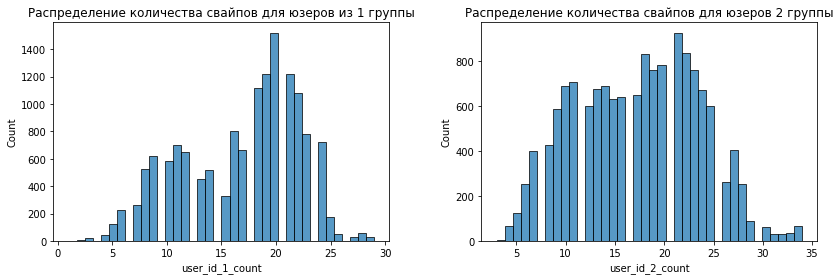

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df['user_id_1_count'], ax=axes[0])
axes[0].set_title('Распределение количества свайпов для юзеров из 1 группы')

sns.histplot(df['user_id_2_count'], ax=axes[1])
axes[1].set_title('Распределение количества свайпов для юзеров 2 группы')

plt.tight_layout() 
plt.show()


Распределение количества взаимодействий/свайпов по юзерам тоже не дало однозначной информации.  
  
  
Приму решение взять за основу то, что у нас есть всего 2000 уникальных пользователей с неуникальными айдишниками на обе группы. То есть присутствует сегментация по каким-либо признакам, например гендерным, между группой user_id_1 и user_id_2.   
  

#### Рассуждения по выбору метрик

Теперь необходимо определить, по каким критериям мы можем определить качество сервиса. Для начала отмечу, я предполагаю, что у нас имеются репрезентативные выборки для каждой экспериментальной пары юзеров, например, рандомным образом брались пользователи за один и тот же промежуток времени.   
Рассмотрим ситуацию со стороны выгоды для нашего сервиса и со стороны юзера на основе наших данных.  
- Со стороны юзера ключевым показателем удовлетворения от сервиса (если рассматривать только предоставленные данные) является наибольшее значение отношения частоты мэтчей на частоту свайпов. Т.е. "чаще мэтчиться - реже свайпать".
- Для нас же важно все: и как часто пользователь свайпал, т.е., как долго клиент пользуется сервисом, и степень удовлетворенности клиента. Отмечу, частота мэтчей, хоть и косвенно будет отражать степень довольности юзера - зачастую дейтинг сервисам будет профитнее искуственно сдерживать пользователей на количество мэтчей, оставляя некоторый буфер потенциальных мэтчей, чтобы пользователь мог получить их, например, при оформлении платных подписок. С другой стороны, если сервис относительно новый, то нашей основной задачей будет привлечь клиентов, а не прибыль в краткосрок. В общем, много ньюансов, на которые пока все-таки посмею закрыть глаза, т.к. данные довольно-таки ограничены, а также в задаче нет ограничения на уровень качественности сервиса, да и многое можно будет сделать уже маркетологам постфактум на основе предоставленных данных.  
  

Как в итоге нам поступить? 
- учитывать интересы пользователей, чтобы благодаря их удовлетворенности оценить, что мы удерживаем их как можно лучше? 
- считать только количество мэтчей? 
- считать только количество свайпов каждого пользователя? Это по идее отразит общее увеличение спроса на сервис  
  
Основой качества сервиса нужно считать заинтересованность аудитории в нем, т.к. это один из ключевых факторов, влияющий на существенное количество других показателей и метрик (RR, сарафанное радио etc.), как итог - на увеличение прибыли. Заинтересованность зависит от удовлетворенности. Поэтому считаю, что здесь необходимо использовать первый подход, как основной, т.е. найти **отношения количества мэтчей на количество свайпов/взаимодействий для каждого пользователя**. Назовем ее **AMOS - Average Matches Of Swipes**. Это наша первая метрика.  
  
  Метрики общих количеств мэтчей или свайпов/взаимодействий тоже довольно полезны для оценки. Проверять буду **метрику средних мэтчей, равное отношению общего числа мэтчей на число юзеров в каждой экспериментальной группе**. Это наша вторая метрика.
    
      
Нам неизвестно, по какому принципу в колонке *is_match* выставляются значения.В задании сказано: *В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.* Что считать под взаимодействием: показ хотя бы одному в подборке или обязательный взаимный показ? То есть это может быть: 
- для юзера из первой колонки. Если свайп без мэтча - 0, если с мэтчем - 1
- для юзера из второй колонки. Если свайп без мэтча - 0, если с мэтчем - 1
- для первого и для второго сразу, не учитывая отказ. Если у обоих друг для друга свайпы без мэтча - 0, если с мэтчем у обоих - 1. В ином случае данные не попадают в наш изначальный фрейм
- для перового и для второго, учитывая отказ. Если у обоих друг для друга взаимные свайпы без мэтча, или с мэтчем, но только для одного - 0, если с мэтчем у обоих - 1  
  
  
Если первые два варианта не совсем совпадают с описанием данных, то и третий, и четвертый будут оба подходить под описание. Я буду рассматривать чуть более подходящий под описание на мой взгляд вариант - четвертый. Таким образом, только если обоим пользователям были осущствлены взаимные показы друг друга -> они попали в логи -> 0 - свайп у обоих, но не мэтч; 1 - мэтч.   
  
  
Последней метрикой будет расчет **конверсии по мэтчам**. Это наша третья метрика.

### Итак, выбранные метрики:
1. **AMOS**. ((Количество мэтчей / количество взаимодействией для пользователя) * 100%) / число пользователей
2. **Среднее число мэтчей**. Общее количество мэтчей / число пользователей
3. **Конверсия по мэтчам**

#### Подготовка к анализу

In [14]:
# Разобьем на группы юзеров
df_user_id_1 = df[['user_id_1', 'group', 'user_id_1_count', 'user_id_1_match_count']].drop_duplicates()
df_user_id_2 = df[['user_id_2', 'group', 'user_id_2_count', 'user_id_2_match_count']].drop_duplicates()


In [15]:
df_user_id_1.rename(columns = {'user_id_1' : 'id', 
                               'user_id_1_count' : 'swipe_count', 
                               'user_id_1_match_count' : 'match_count'},
                   inplace = True)
df_user_id_2.rename(columns = {'user_id_2' : 'id', 
                               'user_id_2_count' : 'swipe_count', 
                               'user_id_2_match_count' : 'match_count'},
                   inplace = True)

`MOS = (Количество мэтчей / количество взаимодействией для пользователя) * 100%`

In [16]:
# Введем колонки с сегментами и метриками MOS
df_user_id_1['segment'] = 1
df_user_id_2['segment'] = 2
df_user_id_1['metrik'] = ((df_user_id_1.match_count / df_user_id_1.swipe_count) * 100).round(2)
df_user_id_2['metrik'] = ((df_user_id_2.match_count / df_user_id_2.swipe_count) * 100).round(2)

In [17]:
df_user_id_1[:1]

,id,group,swipe_count,match_count,segment,metrik
0,79,1,11,4,1,36.36


In [18]:
df_user_id_2[:1]

,id,group,swipe_count,match_count,segment,metrik
0,91,1,20,9,2,45.0


#### Рассуждения по слитию сегментов юзеров

Мы пришли к следующей сложности - имеем две группы, разделенных по непонятно какому признаку. Задача: определить, можно ли их слить или проводить анализ отдельно для каждой группы.  
Скажу вот что, основываясь на логике, имхо, не совсем корректно объединять в одну выборку две, разделенные, скажем, по гендерному признаку. Возможно следовало сделать это отдельно друг от друга, но т.к. распределения почти одинаковы (аргумент "за"):

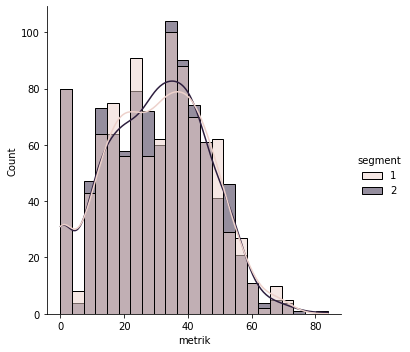

In [19]:
sns.displot(pd.concat([df_user_id_1, df_user_id_2]), x = 'metrik', hue = 'segment', 
             kde = True)
plt.show()

P-value статистического различия средних у двух групп юзеров не позволяет нам ничего сказать (аргумент ни "за", ни "против"):

In [20]:
print(stats.shapiro(df_user_id_1.metrik))
print(stats.shapiro(df_user_id_2.metrik))
print(stats.bartlett(df_user_id_1.metrik, df_user_id_2.metrik))
print(stats.ttest_ind(df_user_id_1.metrik, df_user_id_2.metrik))

ShapiroResult(statistic=0.9822156429290771, pvalue=1.0724484633684028e-09)
ShapiroResult(statistic=0.9835116267204285, pvalue=3.3343956484799264e-09)
BartlettResult(statistic=0.06720735162443046, pvalue=0.7954471327812147)
Ttest_indResult(statistic=0.11145237349285388, pvalue=0.9112688253241665)


Я все-таки солью их, т.к. в задаче ничего не сказано (2.5 аргумента "за" против 0.5 "против").

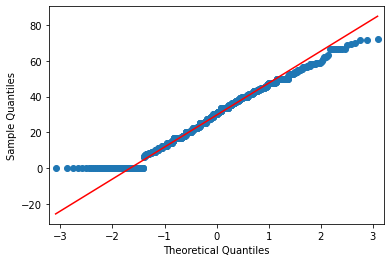

In [21]:
fig = sm.qqplot(df_user_id_1.metrik, line='q')
plt.show()

Сливаем

In [22]:
df_user_id_1['id'] = df_user_id_1['id'] + 1000
df_user_id_2['id'] = df_user_id_2['id'] + 2000

df_total = pd.concat([df_user_id_1, df_user_id_2])

In [23]:
df_total

,id,group,swipe_count,match_count,segment,metrik
0,1079,1,11,4,1,36.36
1,1716,1,20,9,1,45.00
2,1423,0,12,1,1,8.33
3,1658,1,18,13,1,72.22
4,1969,0,11,5,1,45.45
...,...,...,...,...,...,...
6795,2917,1,13,6,2,46.15
7508,2502,0,6,2,2,33.33
7802,2027,0,3,2,2,66.67
8579,2077,0,4,0,2,0.00


In [24]:
df_total.group.value_counts()

0    1002
1     998
Name: group, dtype: int64

Размер выборок для экспериментальных групп уникальных пользователей отличается, но незначительно - оставляем размер в 1000

## Метрика AMOS

Рассчитывается, как среднее метрик MOS или ((Количество мэтчей / количество взаимодействией) * 100%)<sub>user</sub> / число пользователей

In [25]:
# Средние отличаются (но нужно узнать, статистически значимо ли)
df_total.groupby('group', as_index = False).agg({'metrik' : 'mean'})

,group,metrik
0,0,19.320090
1,1,40.243768


$H_0$ - средние значения метрик в двух экспериментальных группах статистически значимо **не различаются**  
$H_0$ - средние значения метрик в двух экспериментальных группах статистически значимо **различаются**   

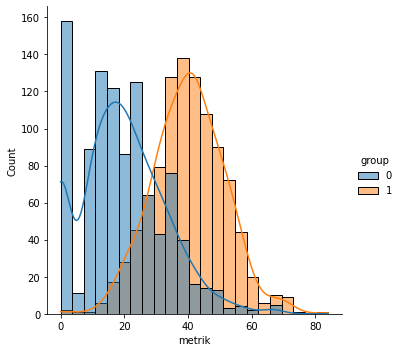

Дисперсия контрольной группы:  174.47780707776062
Дисперсия тестовой группы:  129.129799432934
p-value гомогенности дисперсий:  9.403272284570692e-06

p-value нормальности для контрольной группы:  4.245122137962068e-16
p-value нормальности для тестовой группы:  0.06796706467866898


In [26]:
# Проверим на нормальность распределние эксп. выборок перед применением стат. теста
sns.displot(df_total, x = 'metrik', hue = 'group', kde = True)
plt.show()

print('Дисперсия контрольной группы: ', np.var(df_total.loc[df_total.group == 0].metrik))
print('Дисперсия тестовой группы: ', np.var(df_total.loc[df_total.group == 1].metrik))

print('p-value гомогенности дисперсий: ', stats.levene(df_total.loc[df_total.group == 0].metrik, 
                   df_total.loc[df_total.group == 1].metrik)[1])

print('\np-value нормальности для контрольной группы: ', stats.shapiro(df_total.loc[df_total.group == 0].metrik)[1])
print('p-value нормальности для тестовой группы: ', stats.shapiro(df_total.loc[df_total.group == 1].metrik)[1])

Условия нормальности распределений и гомогенности дисперсий, необходимые для применения критерия Стьюдента - не выполнены, т.к. p-value в обоих случаях меньше &alpha;. Т.к. имеем нулевые значения метрик, пролагорифмировать без потери данных и искажений распределения, путем добавления констант, не выйдет. Поэтому примение непараметрического теста Манна-Уитни для оценки средних будет более подходящим. В свою очередь, т.к. визуально  распределения близки к нормальным, я проведу и Т-тест тоже

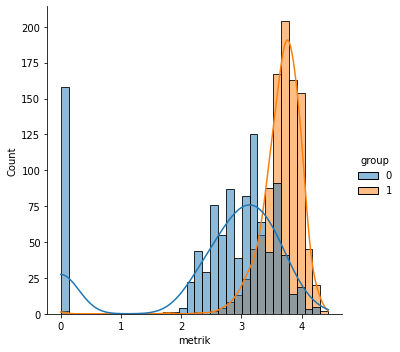

Дисперсия контрольной группы:  1.4352108068052936
Дисперсия тестовой группы:  0.11704086723534979
p-value гомогенности дисперсий:  3.3770368754507246e-67

p-value нормальности для контрольной группы:  1.176644518665185e-35
p-value нормальности для тестовой группы:  6.82398967954609e-31


In [27]:
# Проверим на нормальность распределние эксп. выборок перед применением стат. теста
sns.displot(df_total, x = np.log(df_total.metrik + 1), hue = 'group', kde = True)
plt.show()

print('Дисперсия контрольной группы: ', np.var(np.log(df_total.loc[df_total.group == 0].metrik + 1)))
print('Дисперсия тестовой группы: ', np.var(np.log(df_total.loc[df_total.group == 1].metrik + 1)))

print('p-value гомогенности дисперсий: ', stats.levene(np.log(df_total.loc[df_total.group == 0].metrik + 1), 
                   np.log(df_total.loc[df_total.group == 1].metrik + 1))[1])

print('\np-value нормальности для контрольной группы: ', stats.shapiro(np.log(df_total.loc[df_total.group == 0].metrik + 1))[1])
print('p-value нормальности для тестовой группы: ', stats.shapiro(np.log(df_total.loc[df_total.group == 1].metrik + 1))[1])

#### Тест Манна-Уитни

In [28]:
stats.mannwhitneyu(df_total.loc[df_total.group == 0].metrik,
                   df_total.loc[df_total.group == 1].metrik)

MannwhitneyuResult(statistic=115084.0, pvalue=1.9273608741469226e-195)

#### Т-Тест

In [29]:
stats.ttest_ind(df_total.loc[df_total.group == 0].metrik,
                df_total.loc[df_total.group == 1].metrik)

Ttest_indResult(statistic=-37.9488583614315, pvalue=8.932048526633796e-238)

Т.к. наш p-уровень значимости получился меньше &alpha; (зададим его, как 0.05), то отвергаю $H_0$ и принимаю $H_1$, утверждая, что средние значения кастомных метрик AMOS двух экспериментальных групп статистиески значимо различаются.  
**Таким образом показатель, отражающий среднее отношение мэтчей ко всем взаимодействиям (свайпам) всех пользователей, статзначимо больше в тестовой группе (`40.2%`), чем в контрольной (`19.3%`) на `20.9%`**

# Среднее число мэтчей

Рассчитывается, как общее `общее количество мэтчей / число пользователей`

$H_0$ - средние значения числа мэтчей в двух экспериментальных группах статистически значимо **не различаются**  
$H_1$ - средние значения числа мэтчей в двух экспериментальных группах статистически значимо **различаются**   

In [30]:
# Средние отличаются (но нужно узнать, статистически значимо ли)
df_total.groupby('group', as_index = False).agg({'match_count' : 'mean'})

,group,match_count
0,0,1.864271
1,1,7.833667


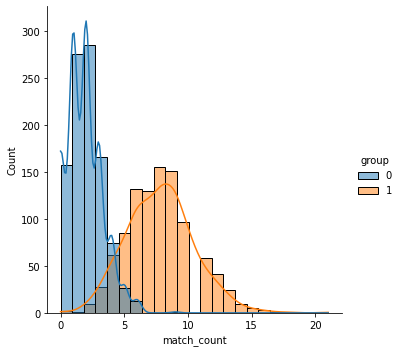

Дисперсия контрольной группы:  1.8518372436763202
Дисперсия тестовой группы:  7.102593965486083
p-value гомогенности дисперсий:  3.6550250503338187e-62

p-value нормальности для контрольной группы:  ShapiroResult(statistic=0.9132312536239624, pvalue=1.7610877946952165e-23)
p-value нормальности для тестовой группы:  ShapiroResult(statistic=0.9803898930549622, pvalue=2.432088419546119e-10)


In [31]:
# Проверим на нормальность распределние эксп. выборок перед применением стат. теста
sns.displot(df_total, x = 'match_count', hue = 'group', kde = True)
plt.show()

print('Дисперсия контрольной группы: ', np.var(df_total.loc[df_total.group == 0].match_count))
print('Дисперсия тестовой группы: ', np.var(df_total.loc[df_total.group == 1].match_count))

print('p-value гомогенности дисперсий: ', stats.levene(df_total.loc[df_total.group == 0].match_count, 
                   df_total.loc[df_total.group == 1].match_count)[1])


print('\np-value нормальности для контрольной группы: ', stats.shapiro(df_total.loc[df_total.group == 0].match_count))
print('p-value нормальности для тестовой группы: ', stats.shapiro(df_total.loc[df_total.group == 1].match_count))

Условия нормальности распределений и гомогенности дисперсий необходимые для применения критерия Стьюдента - не выполнены. Поэтому примение непараметрического теста Манна-Уитни для оценки средних будет более подходящим. Так же, как и в предыдущей метрике - рассчитаю стат значимость и Т-тестом тоже.

#### Тест Манна-Уитни

In [32]:
stats.mannwhitneyu(df_total.loc[df_total.group == 0].match_count,
                   df_total.loc[df_total.group == 1].match_count)

MannwhitneyuResult(statistic=20930.0, pvalue=3.811936940230116e-304)

#### Т-Тест

In [33]:
stats.ttest_ind(df_total.loc[df_total.group == 0].match_count,
                df_total.loc[df_total.group == 1].match_count)

Ttest_indResult(statistic=-63.08819011546484, pvalue=0.0)

In [34]:
# Изменения метрик
df_total.groupby('group', as_index = False).agg({'match_count' : 'mean'})

,group,match_count
0,0,1.864271
1,1,7.833667


Т.к. наш p-уровень значимости в обоих тестах получился меньше &alpha; (0.05), то отвергаю $H_0$ и принимаю $H_1$, утверждая, что средние значения числа мэтчей двух экспериментальных групп статистиески значимо различаются.  
**Таким образом среднее количество мэтчей в тестовой группе равное `7.83` мэтчей статзначимо больше, чем в контрольной, равное `1.86` мэтчей, на `5.97` мэтчей**

# Метрика конверсий по мэтчам

В этом варианте мы будем работать с номинативными переменными. Важно отметить, что в качестве наблюдений мы теперь не будем брать каждого юзера по отдельности. Вместо этого, единицами наблюдений будут являться пары взаимодействий пользователей. Иными словами, взаимные свайпы для пользователей - показы в подорке и у одного, и у другого. Построим таблицу сопряженности частот мэтчей по каждой экспериментальной группе.

### Формулировка гипотез
$H_0$: **Доля мэтчей среди всех пар пользователей не зависит от экспериментальной группы.** То есть статистически значимой взаимосвязи между статусом мэтчам и экспериментальными группами нет.  

$H_1$: **Доля мэтчей среди всех пар пользователей зависит от экспериментальной группы.** То есть существует статистически значимая взаимосвязь между статусом мэтчам и экспериментальными группами.  

In [35]:
conversion_df = df.reset_index().rename(columns = {'index' : 'pair_id'})

In [36]:
conversion_df.groupby('group', as_index = False).agg({'is_match' : 'sum'})

,group,is_match
0,0,934
1,1,3909


Построим таблицу сопраженности частот мэтчей, не мэтчей и всех взаимодействий

In [37]:
crosstab = pd.crosstab(conversion_df.group, conversion_df.is_match, rownames=['group'], colnames=[''])
crosstab['interactions'] = crosstab[0] + crosstab[1]
crosstab = crosstab.append(crosstab.sum(), ignore_index=True) \
    .rename(index = {0 : 'control', 1 : 'test', 2 : 'total'},
            columns = {'is_match' : '', 0 : 'not_match', 1 : 'match'})

In [38]:
crosstab['conversion'] = (crosstab['match'] / crosstab['interactions'] * 100).round(3)

In [39]:
crosstab

,not_match,match,interactions,conversion
control,3858,934,4792,19.491
test,5813,3909,9722,40.208
total,9671,4843,14514,33.368


Условия применения (независимость переменных и количества наблюдений) выполнены. Проведем критерий Хи-квадрат.

#### Тест Хи-квадрат

In [40]:
stats.chi2_contingency(crosstab.drop(columns = 'interactions', index = 'total'))

(619.6383108302939,
 2.800595684585814e-135,
 2,
 array([[3192.8702151 , 1598.91122446,   19.70956044],
        [6478.1297849 , 3244.08877554,   39.98943956]]))

Проведенный тест **Хи-квадрат** дает нам основания опровергнуть $H_0$ и принять  $H_1$, т.к. p-value (1.44e-136) < &alpha;.  
**Мы с более чем 95%-й вероятностью можем быть уверены, что распределение мэтчей среди пар по группам стат значимо различается. Таким образом, в тестовой группе по сравнению с контрольной присутсвует закономерное увеличение конверсии на `~20.7%`**

# Общий вывод

В ходе выполнения анализа были произведены расчеты трех метрик. Первые две, кастомная метрика `AMOS` и метрика `среднего числа мэтчей`, были посчитаны по всем пользователям (2000). Третья метрика, `конверсия в мэтч`, рассчитана по парам взаимодействующих пользователей(1000), изначально присутствующих в наших данных.

Статистический анализ метрики `AMOS` показал, что мы имеем закономерность в увеличении средней доли мэтчей среди взаимодействий по пользователям на `20.9%`. В контрольной группе - `19.3`, в тестовой - `40.2`. Думаю, этот показатель хорошо отражает результат обновленного алгоритма поиска подходящих анкет, т.к. пользователи будут больше удовлетворены при более частых мэтчах при более редких свайпах.

Статистический анализ метрики `среднего числа мэтчей` показал, что увеличение среднего числа мэтчей по пользователям на `5.97` закономерно. В контрольной - `1.86`, в тестовой - `7.83`. Это также отражает положительный результат работы алгоритма, т.к., помимо коррелирования на метрику `AMOS`, по большому числу мэтчей можно сделать различные заключения, например, что пользователи стали более заинтересованы нашим сервисом. Это, хоть и косвенно, но может являться следствием работы нашего алгоритма поиска подходящих анкет.

Статистический анализ метрики `конверсии по мэтчам` показал, что конверсия в мэтч каждой взаимодействующей пары стат значимо увеличилось на `20.7%`. В контрольной группе - `19.5%`, в тестовой - `40.2%`. Отмечу, что эта метрика очень сильно коррелирует с метрикой `AMOS` (отсюда и такие близкие значения), поэтому ее изменения тоже являются положительными результатами работы нашего алгоритмы

В общем, считаю, что данные метрики неплохо оценивают результат работы нового алгоритма.    

**Результаты сравнения метрик `AMOS`, `среднего числа мэтчей` и `конверсии по мэтчам` между экспериментальными группами показали заметные статзначимые увеличения метрик. Поэтому считаю, что алгоритм положительно повлиял на качество сервиса и его стоит включить на всех пользователей.**
